## 加载csv数据

In [1]:
import pandas as pd
import numpy as np

titanic_df = pd.read_csv('./titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 是否存在缺失字段

In [2]:
titanic_df.isna().sum()/titanic_df.isna().count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

## 删除唔关字段
由于Name，Ticket与是否生还没有太大关系，故选择删除，另外仓位其实与是否生还有一定联系，但是从上面统计得知仓位缺失值超过半数，达到77.1%，缺失比例太高，已经没有太大分析意义，故也把该值删除。

In [3]:
# 删除Name，Ticket，Cabin，这些数据和生还率好像都没有什么关系，而且Cabin这个字段还记录不全
# Ticket这个字段对分析毫无作用
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Cabin']
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## 检查是否存在空值

In [4]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

经过统计，观察到Age存在空值，Embarked存在空值，先把Embarked空值的数据打印出来看看是什么数据

In [5]:
# 对登船记录做填充，因为登船记录只有两个数据缺失，所以直接补充为Unknown即可，这两个数据对分析关系不是很大
titanic_df.Embarked.fillna("Unknown", inplace=True)

In [6]:
# 因为年龄缺失值在20%左右，而且据当时历史了解，年龄层次不同与生还直接相关，所有有必要对年龄进行一些填补
# 统计以下填充前的年龄分布情况
titanic_df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
# 对年龄进行中位数填充，直接使用性别分组，统计各个性别年龄中位数进行填充，按照性别来分组，这样统计年龄相对来说比较合理
age_medians = titanic_df.groupby("Sex").Age.median()
print("age median:{}".format(age_medians))
titanic_df.set_index("Sex", inplace=True)
titanic_df.Age.fillna(age_medians, inplace=True)
titanic_df.reset_index("Sex", inplace=True)
titanic_df.Age.describe()

age median:Sex
female    27.0
male      29.0
Name: Age, dtype: float64


count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

## 对填充后的年龄数据做直方图分析

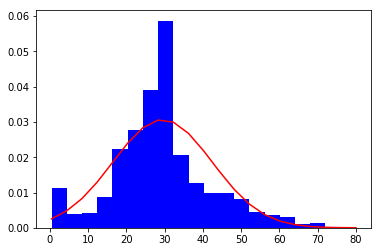

In [8]:
# 对填充后的年龄做一下分布情况统计
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

#据上面的统计，年龄最小的是几个月，最大的是80谁，所以对直方图，设计如下20个区间
num_bins=20
describe = titanic_df.Age.describe()
segma = describe['std']
mu = describe['mean']
plt.close("all")
_, bins, _ = plt.hist(titanic_df.Age, normed=1, bins=num_bins, color="blue")
# 拟合一条正态曲线
line = mlab.normpdf(bins, mu, segma)
plt.plot(bins, line, "red")
plt.show()

从直方图并结合当时的历史环境来看，填充还是比较符合预期
- 20-30岁的青壮、中年占比较多，这部分年龄阶层比较适合长途旅行、商务出行
- 符合当时社会年龄层次分布

## 统计从不同港口登船的人数占比

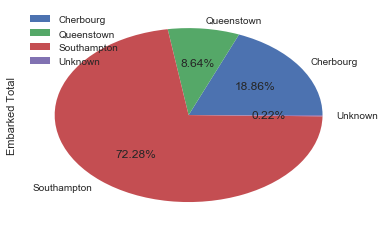

In [9]:
sns.set(color_codes=True)
plt.close('all')
embarked_total = titanic_df.groupby('Embarked').count()
# 生成饼图
labels = ['Cherbourg', 'Queenstown', 'Southampton', 'Unknown']
embarked_total.plot.pie(y='PassengerId', labels=labels, autopct='%1.2f%%')
plt.ylabel('Embarked Total')
plt.show()

<pre>从上图说得，很多旅客是从Southampton登船，其次是Cherbourg，再次是Queenstown，还有两位旅客未知
也因为Southampton是泰坦尼克号的启航地，所以登船人数最多
<pre>
[参考文献](https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7)

In [44]:
def multi_index_groupby_count(index_names, g_as_index=False, ret_cols_names=None):
    if ret_cols_names is not None:
        return titanic_df.groupby(index_names, as_index=g_as_index).count()[ret_cols_names]
    else:
        return titanic_df.groupby(index_names, as_index=g_as_index).count()

def get_index_byvalue(df, index_name, by_val, ret_cols_names=None):
    if ret_cols_names is not None:
        return df.loc[df[index_name] == by_val][ret_cols_names]
    else:
        return df.loc[df[index_name] == by_val]

## 问题1: 仓位等级是否和幸存相关？

In [50]:
survived_total = multi_index_groupby_count(["Pclass", "Survived"], False)
pclass_count = multi_index_groupby_count(["Pclass"], False, ["Pclass", "PassengerId"])

print("统计各等级仓位的总人数：")
print(pclass_count)
print("---------------------------------")

# 把survived_total数据分成两组，一组只有幸存统计，一组只有死亡人数统计
not_surviveds = get_index_byvalue(survived_total, 'Survived', 0, ["Pclass", "PassengerId"])
surviveds = get_index_byvalue(survived_total, 'Survived', 1, ["Pclass", "PassengerId"])

def div_by_cols_val(df, cols_name, map_df, map_cols_name):
    return df[cols_name].div(df[map_cols_name].map(map_df.set_index(map_cols_name)[cols_name]))

# print(div_by_cols_val(not_surviveds, "PassengerId", pclass_count, "Pclass"))

not_surviveds['ratio'] = div_by_cols_val(not_surviveds, "PassengerId", pclass_count, "Pclass")
surviveds['ratio'] = div_by_cols_val(surviveds, "PassengerId", pclass_count, "Pclass")
print(not_surviveds)
print(surviveds)

统计各等级仓位的总人数：
   Pclass  PassengerId
0       1          216
1       2          184
2       3          491
---------------------------------
   Pclass  PassengerId     ratio
0       1           80  0.370370
2       2           97  0.527174
4       3          372  0.757637
   Pclass  PassengerId     ratio
1       1          136  0.629630
3       2           87  0.472826
5       3          119  0.242363


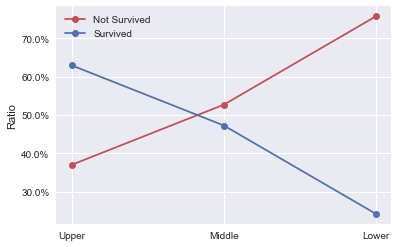

In [51]:
# 绘制比例图形对比结果
from matplotlib.ticker import FuncFormatter

plt.close("all")
def to_percent(y, position):
    return str(100 * y) + '%'
formatter = FuncFormatter(to_percent)
p1 = plt.plot(not_surviveds.Pclass, not_surviveds.ratio, "r-o")
p2 = plt.plot(surviveds.Pclass, surviveds.ratio, "b-o")
x_labels = ["Upper", "Middle", "Lower"]
plt.xticks(not_surviveds.Pclass, x_labels)
plt.ylabel("Ratio")
plt.legend((p1[0], p2[0]), ("Not Survived", "Survived"))
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

从上图可以看出：
- 生还率在阶级层面来看非常分明
- 越是头等舱的乘客越优先获救，头等舱的乘客接近63%被救出
- 3等仓虽然人数众多，但是也接近76%的人没有获救。

## 幸存和性别是否相关？

In [52]:
# 获取不同性别的幸存情况
sex_survived_total = multi_index_groupby_count(["Sex", "Survived"], False, ['Sex', 'Survived', 'PassengerId'])
sex_total = multi_index_groupby_count("Sex", False, ['Sex', 'PassengerId'])
sex_survived_total['ratio']=div_by_cols_val(sex_survived_total, "PassengerId", sex_total, 'Sex')
sex_survived_total

,Sex,Survived,PassengerId,ratio
0,female,0,81,0.257962
1,female,1,233,0.742038
2,male,0,468,0.811092
3,male,1,109,0.188908


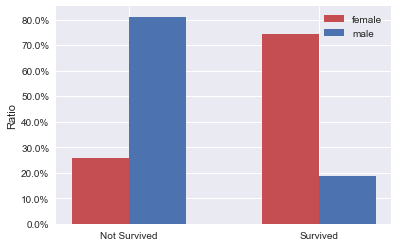

In [66]:
# 画图
female_ratio = sex_survived_total.loc[sex_survived_total['Sex']=='female']
male_ratio = sex_survived_total.loc[sex_survived_total['Sex']=='male']

def create_bar_plot(df1, df2, cols_name, xlabels=None, ylabel=None, bar_width=0.3, df1_label=None, df2_label=None, legend_names=None):
    arange = np.arange(df1[cols_name].count())
    p1 = plt.bar(arange, df1[cols_name], bar_width, color="r", label=df1_label)
    p2 = plt.bar(arange+bar_width, df2[cols_name], bar_width, color="b", label=df2_label)
    x_labels = xlabels
    plt.xticks(arange + bar_width/2, x_labels)
    plt.ylabel(ylabel)
    plt.legend((p1[0], p2[0]), legend_names)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
create_bar_plot(female_ratio, male_ratio, "ratio", ["Not Survived", "Survived"], ylabel="Ratio", df1_label="female", df2_label="male", legend_names=("female", "male"))

女性的幸存比例是男性的3倍有多，可以看出当时欧洲的绅士风度在危难时候依然起作用，大部分女性乘客都优先登上救生艇离开了。

## 年龄和幸存是否相关?
把年龄分成9组：
- 小于10岁，A组
- 10-20岁，B组
- 20-30岁，C组
- 30-40岁，D组
- 40-50岁，E组
- 50-60岁，F组
- 60-70岁，G组
- 70-80岁，H组
- 大于80岁,G组

In [57]:
# 年龄分段函数
def change_Age_group(val):
    if val <= 10:
        return 'A'
    if val > 10 and val <= 20:
        return 'B'
    if val > 20 and val <= 30:
        return 'C'
    if val > 30 and val <= 40:
        return 'D'
    if val > 40 and val <= 50:
        return 'E'
    if val > 50 and val <= 60:
        return 'F'
    if val > 60 and val <= 70:
        return 'G'
    if val > 70 and val <= 80:
        return 'H'
    if val > 80:
        return 'G'
titanic_df['Age_Level'] = titanic_df.Age.apply(change_Age_group)

   Survived Age_Level  PassengerId  survived_ratio
0         0         A           26        0.406250
1         0         B           71        0.617391
2         0         C          271        0.665848
3         0         D           86        0.554839
4         0         E           53        0.616279
5         0         F           25        0.595238
6         0         G           13        0.764706
7         0         H            4        0.800000


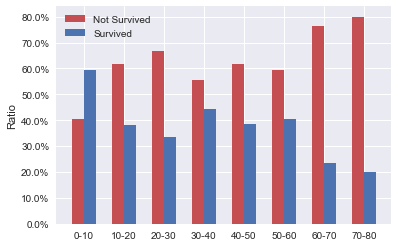

In [75]:
s_age_group = multi_index_groupby_count(['Survived', 'Age_Level'], False, ['Survived', 'Age_Level', 'PassengerId'])
age_count = multi_index_groupby_count('Age_Level', False, ['Age_Level', 'PassengerId'])
s_age_group['survived_ratio'] = div_by_cols_val(s_age_group, 'PassengerId', map_df=age_count, map_cols_name='Age_Level')

# 数据分组
ns_df = s_age_group.loc[s_age_group['Survived'] == 0]
s_df = s_age_group.loc[s_age_group['Survived'] == 1]
print(ns_df)

# x轴标签
x_labels=["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"]
cols_name = "survived_ratio"
ylabel="Ratio"
df1_label="Not Survived", 
df2_label="Survived", 
legend_names=("Not Survived", "Survived")
create_bar_plot(ns_df, s_df, cols_name, x_labels, ylabel=ylabel, df1_label=df1_label, df2_label=df2_label, legend_names=legend_names)

从幸存率来看，年龄越小，幸存率越高（蓝色部分）。
但是0-10岁的死亡率相对于自身来说，还是有点高，从上面的统计可以看出，大概有26名儿童是没有被救的。

## 为什么0-10有40%的儿童没有幸存下来？